In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax

import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



['/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxe3xcuda11p39/lib/python39.zip', '/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxe3xcuda11p39/lib/python3.9', '/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxe3xcuda11p39/lib/python3.9/lib-dynload', '', '/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxe3xcuda11p39/lib/python3.9/site-packages', '/pchem-data/meuwly/boittier/home/jaxeq', '/home/boittier/jaxeq/dcmnet']
[cuda(id=0)]
gpu
[cuda(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [3]:
class Args:
    def __init__(self):
        self.data_dir = "/pchem-data/meuwly/boittier/home/jaxeq/"
        self.esp_w = 1000
        self.n_mp = 2
        self.learning_rate = 0.0001
        self.num_epochs = 2
        self.restart = None
        self.data = "qm9-esp40000-0.npz"
        self.num_epics = 1
        self.random_seed = 0
        self.n_dcm = 2
        


In [4]:
args = Args()

In [5]:
NATOMS = 60
data_key, train_key = jax.random.split(jax.random.PRNGKey(args.random_seed), 2)

# Model hyperparameters.
features = 16
max_degree = 2
num_iterations = args.n_mp
num_basis_functions = 8
cutoff = 4.0

n_dcm = 4
# Training hyperparameters.
learning_rate = args.learning_rate
batch_size = 1
esp_w = args.esp_w
restart_params = args.restart
if restart_params is not None:
    restart_params = pd.read_pickle(restart_params)
params = restart_params
data_file = Path(args.data_dir) / args.data

# train_data, valid_data = prepare_datasets(
#     data_key, args.ntrain, args.nvalid, filename=data_file
# )

train_data, valid_data = prepare_datasets(
    data_key,
    # 120000 - 6908,
    # 40000 - 6907,
    # 6907,
    int(80000*0.5),
    int(80000*0.1),
    # 1,
    # 10,
    # 1,
    # 1,
    [
        Path(args.data_dir) / "data/qm9-esp-dip-40000-0.npz", 
        Path(args.data_dir) / "data/qm9-esp-dip-40000-1.npz", 
        Path(args.data_dir) / "data/qm9-esp-dip-40000-2.npz", 
        # Path(args.data_dir) / "data/qm9-esp-dip-6907-3.npz", 
        # Path(args.data_dir) / "data/qm9-esp-dip-1000-0.npz", 
        # Path(args.data_dir) / "data/qm9-esp-dip-1000-1.npz", 
        # Path(args.data_dir) / "data/qm9-esp-dip-1000-2.npz", 
     # Path(args.data_dir) / "data/qm9-esp40000-1.npz", 
     # Path(args.data_dir) / "data/qm9-esp40000-2.npz",
       # Path(args.data_dir) / "data/qm9-esp6907-3.npz" 
    ]
)





R (40000, 60, 3)
Z (40000, 60)
N (40000,)
D (40000,)
com (40000, 3)
Dxyz (40000, 3)
mono (40000, 60, 1)
esp (40000, 3200)
id (40000,)
n_grid (40000,)
vdw_surface (40000, 3200, 3)
R (40000, 60, 3)
Z (40000, 60)
N (40000,)
D (40000,)
com (40000, 3)
Dxyz (40000, 3)
mono (40000, 60, 1)
esp (40000, 3200)
id (40000,)
n_grid (40000,)
vdw_surface (40000, 3200, 3)
R (40000, 60, 3)
Z (40000, 60)
N (40000,)
D (40000,)
com (40000, 3)
Dxyz (40000, 3)
mono (40000, 60, 1)
esp (40000, 3200)
id (40000,)
n_grid (40000,)
vdw_surface (40000, 3200, 3)
120000


In [10]:
# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)
message_passing_model

MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 8
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
)

In [7]:
num_epochs = args.num_epochs


In [9]:
# PARAMS = pd.read_pickle(
#     "/pchem-data/meuwly/boittier/home/jaxeq/runs6/"\
#     "20240828-152758dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_100_params.pkl")

# PARAMS = pd.read_pickle(
#     "/pchem-data/meuwly/boittier/home/jaxeq/runs7/"\
#     # "20240829-145230dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")
# "20240829-225716dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")
# # 
# PARAMS = pd.read_pickle(
#     "/pchem-data/meuwly/boittier/home/jaxeq/runs7/"\
#     # "20240830-113204dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")
# # 
#     "20240830-122426dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")

# params = "/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs8/"\
# "20240920-122013dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_100000_params.pkl"
# PARAMS = pd.read_pickle(params)

params = "/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs7/20240830-163232dcm-4-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl"
PARAMS = pd.read_pickle(params)

In [ ]:
# make checkpoint directory
safe_mkdir(f"/pchem-data/meuwly/boittier/jaxeq/checkpoints2/dcm{n_dcm}-{esp_w}")
isRestart = args.restart is not None
# Set up TensorBoard writer
log_dir = (
    "/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs8/"
    + time.strftime("%Y%m%d-%H%M%S")
    + f"dcm-{n_dcm}-espw-{esp_w}-{args.data}-re-{isRestart}"
)
writer = SummaryWriter(log_dir)
print(log_dir)
with open(log_dir + "/manifest.txt", "w") as f:
    f.write(str(message_passing_model))
    for k, v in vars(args).items():
        f.write(f"\n{k} = {v}")

for epic in range(1, args.num_epics + 1):
    print(f"epic {epic}")
    params, val = train_model_dipo(
        key=train_key,
        model=message_passing_model,
        train_data=train_data,
        valid_data=valid_data,
        num_epochs=100,
        learning_rate=learning_rate/400,
        batch_size=batch_size,
        writer=writer,
        restart_params=PARAMS,
        esp_w=100000,
        ndcm=message_passing_model.n_dcm,
    )

    # open a file, where you want to store the data
    with open(
        f"/pchem-data/meuwly/boittier/home/jaxeq/checkpoints2/dcm{n_dcm}-{esp_w}/{epic}-{val}-esp_params.pkl",
        "wb",
    ) as file:
        pickle.dump(params, file)

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs8/20240923-123520dcm-4-espw-1000-qm9-esp40000-0.npz-re-False
epic 1
Preparing batches
..................
epoch:   1      train:   valid:
    loss [a.u.]              1.941e-01  1.860e-01
epoch:   2      train:   valid:
    loss [a.u.]              1.829e-01  1.796e-01
epoch:   3      train:   valid:
    loss [a.u.]              1.778e-01  1.755e-01
epoch:   4      train:   valid:
    loss [a.u.]              1.744e-01  1.726e-01
epoch:   5      train:   valid:
    loss [a.u.]              1.718e-01  1.703e-01
epoch:   6      train:   valid:
    loss [a.u.]              1.698e-01  1.685e-01
epoch:   7      train:   valid:
    loss [a.u.]              1.682e-01  1.670e-01
epoch:   8      train:   valid:
    loss [a.u.]              1.668e-01  1.657e-01
epoch:   9      train:   valid:
    loss [a.u.]              1.656e-01  1.646e-01
epoch:  10      train:   valid:
    loss [a.u.]              1.645e-01  1.635e-01


In [9]:

# PARAMS = pd.read_pickle(
#     "/pchem-data/meuwly/boittier/home/jaxeq/runs7/"\
#     "20240829-145230dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")

In [10]:
valid_batches = prepare_batches(data_key, valid_data, batch_size, include_id=True)

In [11]:
# valid_batches = prepare_batches(data_key, train_data, batch_size, include_id=True)

In [28]:
batch = valid_batches[-1]

In [29]:
mono_test = batch["mono"]
positions_test = batch["R"]
D_test = batch["D"][0]
com_test = batch["com"][0]


In [30]:
pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
print(batch["Dxyz"][0])
pred_D, D_test, abs(pred_D - D_test)

[-0.09370929  0.3760829  -0.63019388]
[-0.0463749  0.1506537 -0.4533559]


(np.float64(1.398094732642288),
 np.float64(1.219982124315413),
 np.float64(0.17811260832687492))

In [31]:
jnp.mean(optax.l2_loss(pred_D, D_test))

Array(0.01586205, dtype=float32)

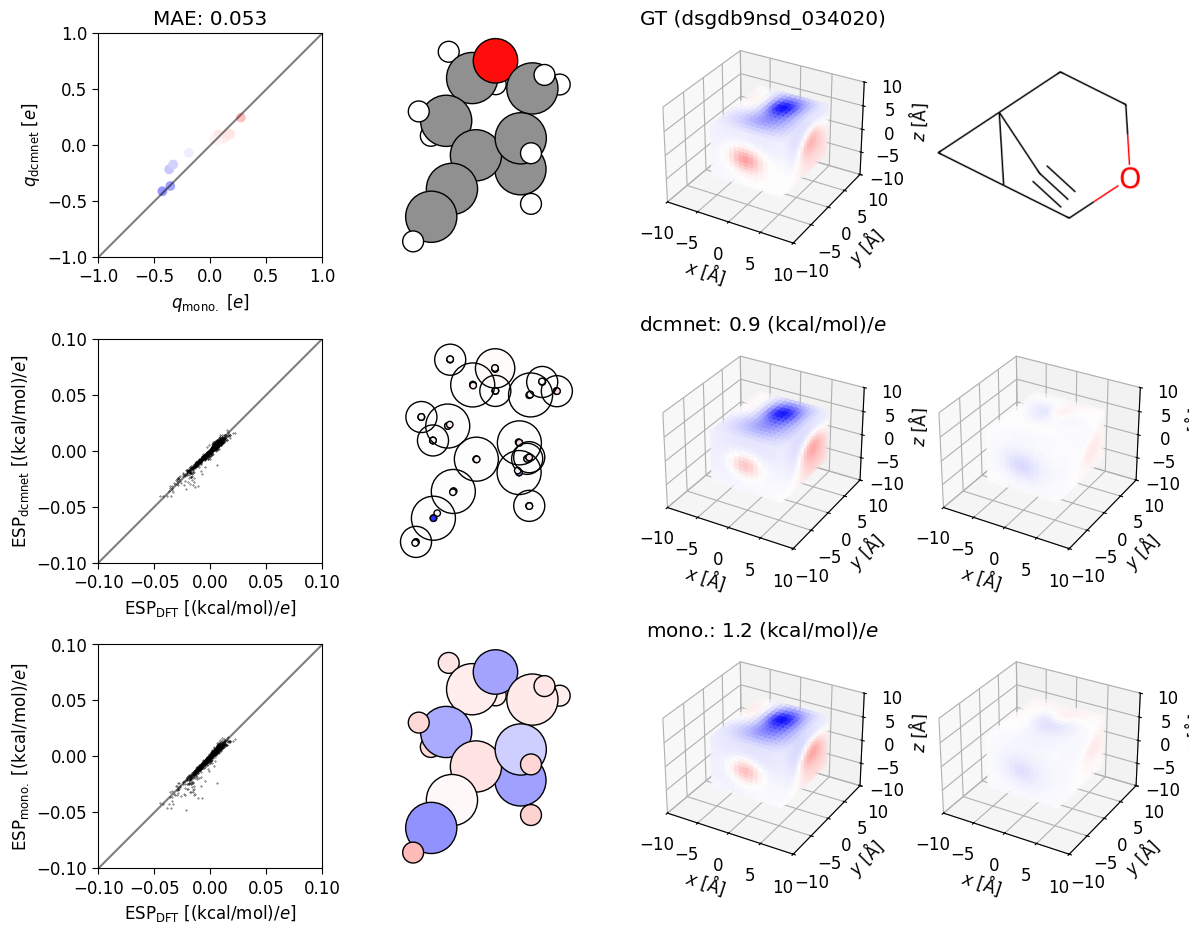

In [32]:

mono, dipo = apply_model(message_passing_model, params, batch, batch_size)
error, esp, keys, _ = evaluate_dc(batch, dipo, mono, batch_size, message_passing_model.n_dcm,
                                       plot="test",
                                       id=True,
                              )

In [33]:
dipo.shape

(180, 3)

In [34]:
pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(message_passing_model.n_dcm * 60, 1))
print(batch["Dxyz"][0])
pred_D, D_test, abs(pred_D - D_test)

[-0.0487706   0.33614647 -0.65795135]
[-0.0463749  0.1506537 -0.4533559]


(np.float32(1.3992549),
 np.float64(1.219982124315413),
 np.float64(0.17927279378303673))

In [35]:
jnp.mean(optax.l2_loss(pred_D, D_test))

Array(0.01606937, dtype=float32)